Linear Regression assumptions: 
    1. Predictor and outcome move in the same or opposite direction.
    2. Data are normally distributed (parametric).
    3. No collinearity between predictors.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn import metrics, feature_selection, preprocessing
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

In [11]:
#get an idea about the dataset
df_bk = pd.read_csv('data/train.csv')
print(df_bk.head())
print(df_bk.isnull().sum())
print(df_bk.count())
print(df_bk.describe())

              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64
datetime      

In [12]:
print(list(df_bk.columns))

['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']


temp  skewness:  0.0036903358354289715
atemp  skewness:  -0.10254538108264065
humidity  skewness:  -0.0863232869219358
windspeed  skewness:  0.5886853963635482
casual  skewness:  2.495404491505502
registered  skewness:  1.5245944734221468
count  skewness:  1.241895058803035


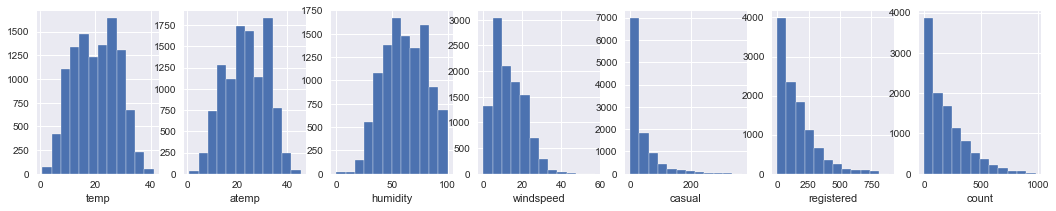

In [13]:
#check the distributions of the continuous variables
fig1, axes = plt.subplots(nrows=1, ncols=7, sharey=False, figsize=(18, 3))
axes = axes.flat
cols = list(df_bk.columns)

for ax, name in zip(axes, cols[5:]):
    ax.hist(df_bk[name], bins=12, edgecolor='white')
    ax.set_xlabel(name)
    print (name, ' skewness: ', scipy.stats.skew(df_bk[name]))

plt.show()
plt.close()

It is important to use preprocessing.scale to reshape the continuous predictors.

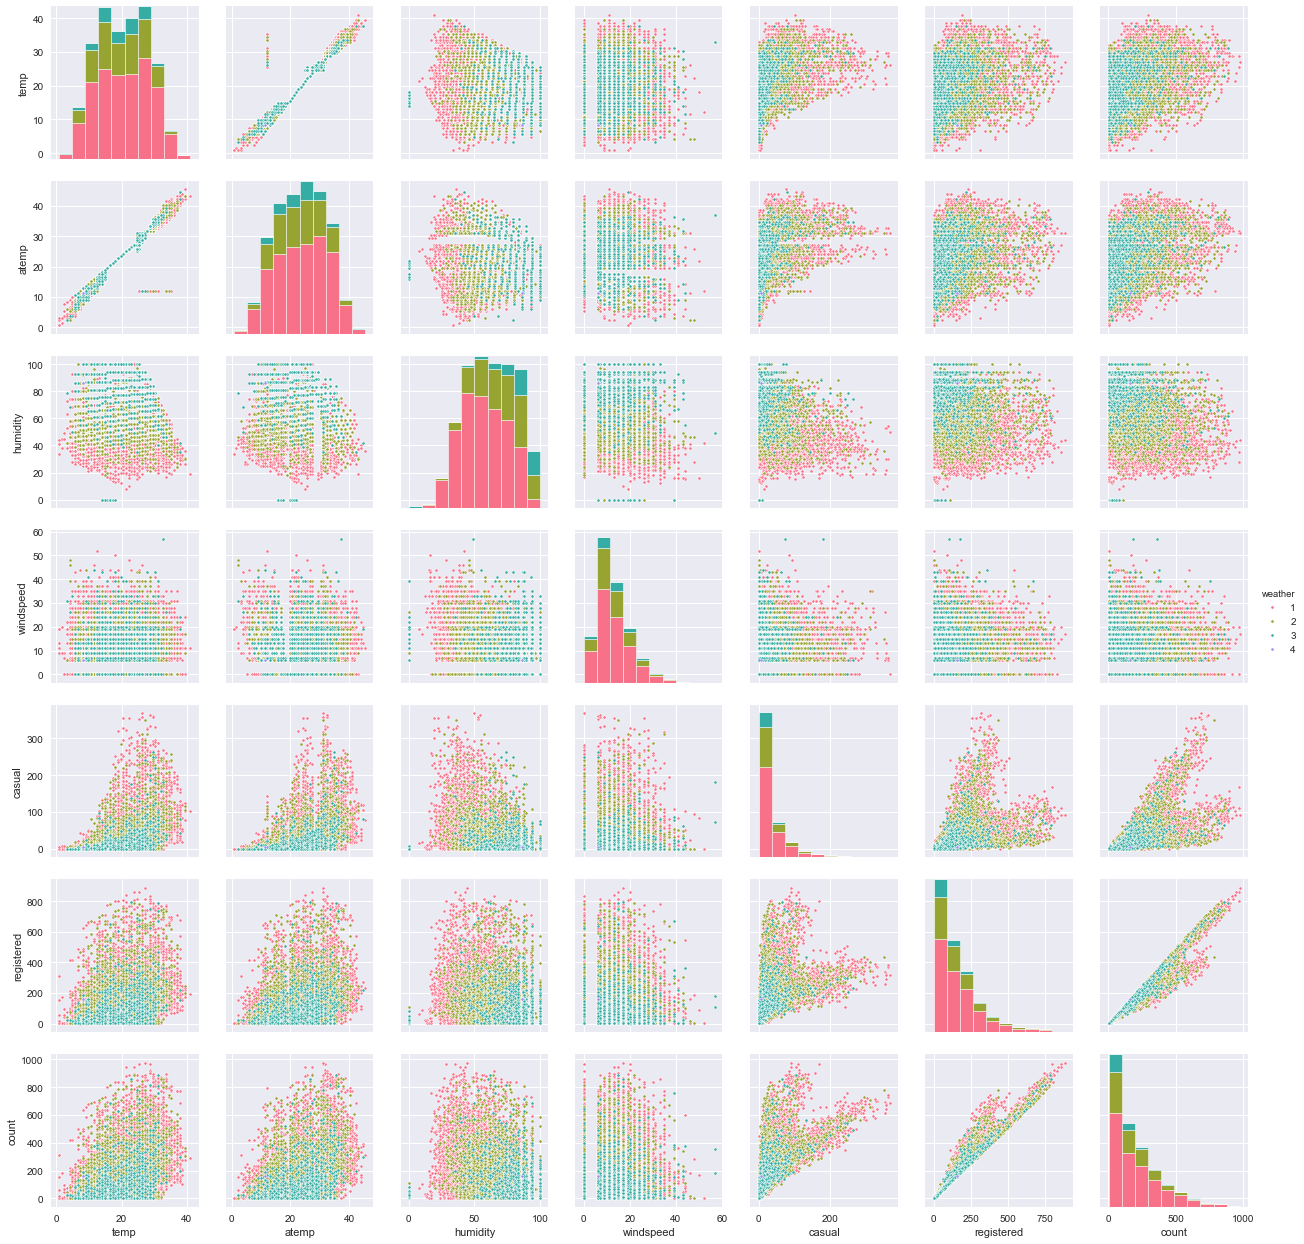

In [27]:
#plot pair grid to find potential linear relations and collinearity for the continuous variables

g = sns.PairGrid(data=df_bk, 
                 hue='weather', 
                 hue_order=None, 
                 palette='husl', 
                 #hue_kws={"marker": ["o", 's', "D", '+']}, 
                 vars=['temp','atemp','humidity','windspeed','casual','registered','count'],
                 x_vars=None, 
                 y_vars=None, 
                 diag_sharey=False, 
                 size=2.5, 
                 aspect=1, 
                 despine=True, 
                 dropna=True)
    
g = g.map_diag(plt.hist, edgecolor="white", linewidth=0.5)
g = g.map_offdiag(plt.scatter, edgecolor="white", linewidth=0.5, s=10)
g = g.add_legend()

sns.plt.show()
sns.plt.close()

collinearity between temp and atemp, registered and count.

In [14]:
#dummy code the categorial variables if regression is going to be done with those variables.

weather = pd.get_dummies(df_bk['weather'], prefix='weather').drop('weather_1', axis=1)
season = pd.get_dummies(df_bk['season'], prefix='season').drop('season_1', axis=1)

###workingday and holiday are binary data. Dummy coding is not required.
#workingday = pd.get_dummies(df_bk['workingday'], prefix='work').drop('work_1', axis=1)
#holiday = pd.get_dummies(df_bk['holiday'], prefix='hol').drop('hol_1', axis=1)

In [15]:
#hypothesis: causal rides increase because of higher temperature, lower windspeed, lower humidity...
#registered and count values are not useful for prediction purpose
#create a new dataframe
df1 = df_bk[['casual','temp','humidity','windspeed','holiday','workingday']].join(weather).join(season)

#define polynomial features and create df2
pn = preprocessing.PolynomialFeatures(degree=2,interaction_only=True)
X_pn = pn.fit_transform(df1[['temp','humidity','windspeed','holiday','workingday']])
df2 = df1.join(pd.DataFrame(X_pn)).drop(['temp','humidity','windspeed','holiday','workingday'],axis=1)

#use transformed varible (parametric data) for better fitting performance.
#reshape the predictors, including dummies for normal distribution
#create scaler, transform df2, define scaled X and y
scaler = preprocessing.StandardScaler().fit(df2)
df2_sca = scaler.transform(df2)
X_sca = df2_sca[:,1:]
y_sca = df2_sca[:,0]

#k-fold cv
kf = KFold(n_splits=5, shuffle=True)

#Do a grid search with CV
a_list = np.logspace(-5,10,num=5,base=10.0)
gs = GridSearchCV(estimator=Ridge(), 
                  param_grid={'alpha':a_list},
                  cv=kf,
                  scoring='r2', 
                  return_train_score=True)
mod1 = gs.fit(X_sca, y_sca)
print(pd.DataFrame(mod1.cv_results_))
print (mod1.best_estimator_)
print ('\n','Best Mean Test Score: ', mod1.best_score_)
print ('\n','Best Intercept: ', mod1.best_estimator_.intercept_)
print ('\n',pd.DataFrame({'Best Coefficients':mod1.best_estimator_.coef_}))

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       0.004333         0.000355         0.543539          0.546267   
1       0.005169         0.000476         0.543539          0.546267   
2       0.005580         0.000372         0.522080          0.524378   
3       0.002872         0.000393         0.008063          0.008110   
4       0.002431         0.000239        -0.000016          0.000001   

   param_alpha                     params  rank_test_score  split0_test_score  \
0        1e-05           {'alpha': 1e-05}                2           0.542132   
1    0.0562341  {'alpha': 0.056234132519}                1           0.542131   
2      316.228   {'alpha': 316.227766017}                3           0.517989   
3  1.77828e+06   {'alpha': 1778279.41004}                4           0.008369   
4        1e+10   {'alpha': 10000000000.0}                5          -0.000007   

   split0_train_score  split1_test_score       ...         split2_test_score  \


In [ ]:
#get more information for each round of K-fold CV to make sure kf was working fine

def get_model_metrics(X_train, y_train, X_test, y_test, algo):
    # get the pvalue of X given y. Ignore f-stat for now.
    pvals = feature_selection.f_regression(X_train, y_train)[1]
    fstat = feature_selection.f_regression(X_train, y_train)[0]
    # start with an empty linear regression object
    # .fit() runs the linear regression function on X and y
    model = algo.fit(X_train,y_train)
    #residuals = (y-algo.predict(X)).values
    cv_mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    cv_r2 = metrics.r2_score(y_test, model.predict(X_test))
    out_stat = pd.DataFrame({'P Value':pvals, 
                            'F-statistic':fstat, 
                            'Coefficients':algo.coef_})
    # print the necessary values
    print (out_stat)
    print ('y-intercept:', algo.intercept_)
    print ('R-Squared:', algo.score(X_train,y_train))
    print ('CV R-Squared:', cv_r2)
    print ('CV MSE:', cv_mse)
    return model, cv_mse, cv_r2

mse_values = []
r2_scores = []
n= 0
kf1 = KFold(n_splits=5, shuffle=True).split(X_sca, y_sca)
for train_ix, test_ix in kf1:
    n+=1
    print ('Model', n)
    mod2, cv_mse, cv_r2 = get_model_metrics(X_sca[train_ix], y_sca[train_ix], 
                                            X_sca[test_ix], y_sca[test_ix], 
                                            Ridge(alpha=0)) # LinearRegression(), Ridge(), Lasso(), et al.
    mse_values.append(cv_mse)
    r2_scores.append(cv_r2)
    print ('\n')

print ("~~~~ SUMMARY OF K-FOLD CROSS VALIDATION ~~~~")
print ('Mean CV R-Squared:', np.mean(r2_scores))
print ('Mean CV MSE:', np.mean(mse_values))

In [8]:
#Do a grid search with CV
#use SVR
kf = KFold(n_splits=5, shuffle=True)
param3 = {'kernel':['linear'],
         'epsilon':[0.2,0.3,0.4]}
gs = GridSearchCV(estimator=SVR(), 
                  param_grid=param3,
                  cv=kf,
                  scoring=None, 
                  return_train_score=True)
mod3 = gs.fit(X_sca, y_sca)
print(pd.DataFrame(mod3.cv_results_))
print (mod3.best_estimator_)
print ('\n','Best Mean Test Score: ', mod3.best_score_)
#print ('\n','Best Intercept: ', mod1.best_estimator_.intercept_)
#print ('\n',pd.DataFrame({'Best Coefficients':mod1.best_estimator_.coef_}))

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       7.540978         0.229982         0.521572          0.524078   
1       5.354422         0.176404         0.524639          0.527427   
2       4.258280         0.141546         0.526640          0.529133   

  param_epsilon param_kernel                                params  \
0           0.2       linear  {'epsilon': 0.2, 'kernel': 'linear'}   
1           0.3       linear  {'epsilon': 0.3, 'kernel': 'linear'}   
2           0.4       linear  {'epsilon': 0.4, 'kernel': 'linear'}   

   rank_test_score  split0_test_score  split0_train_score       ...         \
0                3           0.532179            0.522415       ...          
1                2           0.533713            0.524813       ...          
2                1           0.535804            0.527823       ...          

   split2_test_score  split2_train_score  split3_test_score  \
0           0.552616            0.510882           0.5

In [43]:
kf = KFold(n_splits=5, shuffle=True)
param4 = {'kernel':['poly'],
         'epsilon':[0.2,0.3,0.4],
         'degree':[2,3,4]}
gs = GridSearchCV(estimator=SVR(), 
                  param_grid=param4,
                  cv=kf,
                  scoring=None, 
                  return_train_score=True)
mod4 = gs.fit(X_sca, y_sca)
print(pd.DataFrame(mod4.cv_results_))
print (mod4.best_estimator_)
print ('\n','Best Mean Test Score: ', mod4.best_score_)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       2.481300         0.259215         0.558442          0.568346   
1       1.917703         0.197744         0.561372          0.570897   
2       1.532411         0.177746         0.558443          0.567826   
3       3.821983         0.262747         0.588403          0.607836   
4       2.549975         0.208019         0.588077          0.608119   
5       2.029142         0.171269         0.585196          0.604876   
6      33.287072         0.272168         0.563449          0.598899   
7      12.525909         0.213425         0.558268          0.599034   
8       8.022523         0.172636         0.560962          0.592947   

  param_degree param_epsilon param_kernel  \
0            2           0.2         poly   
1            2           0.3         poly   
2            2           0.4         poly   
3            3           0.2         poly   
4            3           0.3         poly   
5        

In [9]:
kf = KFold(n_splits=5, shuffle=True)
param5 = {'kernel':['rbf'],
         'epsilon':[0.2,0.3,0.4]}
gs = GridSearchCV(estimator=SVR(), 
                  param_grid=param5,
                  cv=kf,
                  scoring=None, 
                  return_train_score=True)
mod5 = gs.fit(X_sca, y_sca)
print(pd.DataFrame(mod5.cv_results_))
print (mod5.best_estimator_)
print ('\n','Best Mean Test Score: ', mod5.best_score_)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       2.584173         0.394772         0.606556          0.622722   
1       1.896673         0.300730         0.607651          0.623457   
2       1.537519         0.242209         0.607211          0.623077   

  param_epsilon param_kernel                             params  \
0           0.2          rbf  {'epsilon': 0.2, 'kernel': 'rbf'}   
1           0.3          rbf  {'epsilon': 0.3, 'kernel': 'rbf'}   
2           0.4          rbf  {'epsilon': 0.4, 'kernel': 'rbf'}   

   rank_test_score  split0_test_score  split0_train_score       ...         \
0                3           0.607238            0.623399       ...          
1                1           0.606352            0.623023       ...          
2                2           0.604950            0.622810       ...          

   split2_test_score  split2_train_score  split3_test_score  \
0           0.616197            0.622720           0.604961   
1  

In [82]:
#try logistic regression
casual_b = df1['casual'].apply(lambda x: 1 if x > 0 else 0)

kf = KFold(n_splits=5, shuffle=True)
param6 = {'solver':['liblinear'],
         'penalty':['l1','l2']}
gs = GridSearchCV(estimator=LogisticRegression(), 
                  param_grid=param6,
                  cv=kf,
                  scoring='f1', 
                  return_train_score=True)
mod6 = gs.fit(X_sca, np.array(casual_b))
print(pd.DataFrame(mod6.cv_results_))
print(mod6.best_estimator_)
print('\n','Best f1 Score: ', mod6.best_score_)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       0.291649         0.000957         0.952986          0.953025   
1       0.041864         0.000881         0.952536          0.952990   

  param_penalty param_solver                                    params  \
0            l1    liblinear  {'penalty': 'l1', 'solver': 'liblinear'}   
1            l2    liblinear  {'penalty': 'l2', 'solver': 'liblinear'}   

   rank_test_score  split0_test_score  split0_train_score       ...         \
0                1           0.950629            0.953488       ...          
1                2           0.950375            0.953540       ...          

   split2_test_score  split2_train_score  split3_test_score  \
0           0.949456            0.953414           0.952703   
1           0.948947            0.953460           0.952703   

   split3_train_score  split4_test_score  split4_train_score  std_fit_time  \
0            0.953002           0.955432            0.952

In [20]:
#try sklearn.neural_network.MLPRegressor

kf = KFold(n_splits=5, shuffle=True)
param7 = {'activation':['tanh','relu'],
          'solver':['lbfgs'],
          'hidden_layer_sizes':(125,150,175,)}
gs = GridSearchCV(estimator=MLPRegressor(), 
                  param_grid=param7,
                  cv=kf,
                  scoring=None, 
                  return_train_score=True)
mod7 = gs.fit(X_sca, y_sca)
print(pd.DataFrame(mod7.cv_results_))
print(mod7.best_estimator_)
print('\n','Best Score: ', mod7.best_score_)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       6.002897         0.004635         0.649677          0.696925   
1       6.325767         0.005244         0.648495          0.692677   
2       7.579418         0.006884         0.650390          0.691695   
3       3.771979         0.002645         0.659554          0.723526   
4       4.480578         0.003222         0.624926          0.729018   
5       5.369481         0.003979         0.655975          0.731811   

  param_activation param_hidden_layer_sizes param_solver  \
0             tanh                      125        lbfgs   
1             tanh                      150        lbfgs   
2             tanh                      175        lbfgs   
3             relu                      125        lbfgs   
4             relu                      150        lbfgs   
5             relu                      175        lbfgs   

                                              params  rank_test_score  \
0

In [23]:
#try sklearn.tree.DecisionTreeRegressor

kf = KFold(n_splits=5, shuffle=True)
param8 = {'max_features':['auto']}
gs = GridSearchCV(estimator=DecisionTreeRegressor(), 
                  param_grid=param8,
                  cv=kf,
                  scoring=None, 
                  return_train_score=True)
mod8 = gs.fit(X_sca, y_sca)
print(pd.DataFrame(mod8.cv_results_))
print(mod8.best_estimator_)
print('\n','Best Score: ', mod8.best_score_)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       0.051670         0.001314         0.406958          0.975217   
1       0.014707         0.000891         0.406086          0.975217   

  param_max_features                    params  rank_test_score  \
0               auto  {'max_features': 'auto'}                1   
1               sqrt  {'max_features': 'sqrt'}                2   

   split0_test_score  split0_train_score  split1_test_score       ...         \
0           0.412838            0.973421           0.438459       ...          
1           0.399007            0.973421           0.406706       ...          

   split2_test_score  split2_train_score  split3_test_score  \
0           0.375164            0.975353           0.348421   
1           0.396696            0.975353           0.427108   

   split3_train_score  split4_test_score  split4_train_score  std_fit_time  \
0            0.978267           0.459906             0.97399      0.0035